In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

## 데이터 로드

In [6]:
import os
os.getcwd()

'C:\\Users\\강태희'

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [3]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2.데이터 정제

In [7]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

150,000개 데이터 중 약 4000개가 중복인 상태

In [8]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
# 중복 제거됐는지 확인
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

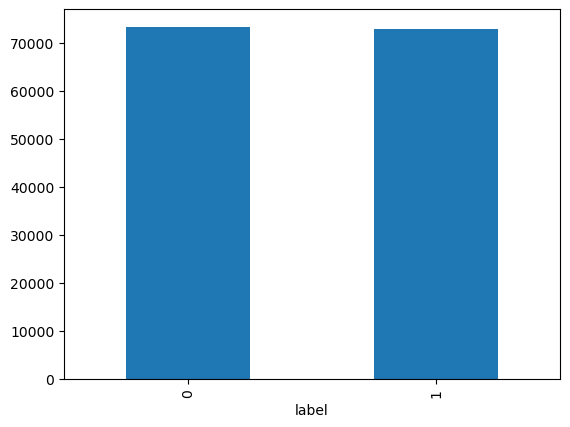

In [10]:
#train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블 값의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
# 레이블 긍, 부정 개수 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [12]:
# 리뷰 중에 결측값이 있는지 확인
print(train_data.isnull().values.any())

True


In [13]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
# 25857 인덱스에 결측값 있음을 확인함
# 결측값 행 삭제하기
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [16]:
print(len(train_data))

146182


In [17]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


- 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거된 것을 확인 
- 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈 값이 되었을 것 
- train_data에 공백만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경

In [18]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


C:\Users\강태희\AppData\Local\Temp\ipykernel_20852\3966077745.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [19]:
# Null 값이 789개나 새로 생성되었음
# Null 행 출력해서 확인해볼 것
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [20]:
# Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있다. 즉, 아무런 의미도 없는 데이터므로 제거한다
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [21]:
#  테스트 데이터에 앞서 진행한 전처리 과정을 동일하게 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


C:\Users\강태희\AppData\Local\Temp\ipykernel_20852\2514788616.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


## 3. 토큰화

In [23]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [24]:
mecab = Mecab(dicpath = 'C:/mecab/mecab-ko-dic')
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

In [25]:
#train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████| 145393/145393 [00:18<00:00, 7884.98it/s]


In [26]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [27]:
# 테스트 데이터에 대해서도 동일하게 토큰화 진행
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 48852/48852 [00:06<00:00, 7300.09it/s]


In [28]:
print(X_test[:3])

[['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아'], ['지루', '않', '은데', '완전', '막장', '돈', '주', '보', '기']]


## 4. 학습 데이터, 검증 데이터, 테스트 데이터 준비

이미 학습 데이터와 테스트 데이터는 준비되었지만 학습하는 동안의 성능 평가를 진행할 검증 데이터가 추가로 필요하다

In [29]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [30]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


## 5. 단어 집합 만들기

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 힌다

In [32]:
# 훈련 데이터에 대해서 단어 집합을 생성
word_list = []   # 모든 단어를 다 모아둘 빈 리스트 생성
for sent in X_train:  # sent = 한 문장 (단어들의 리스트)
    for word in sent:  # word = 문장 안의 단어 하나 
      word_list.append(word) # 모든 문장을 돌면서 그 안에 있는 모든 단어를 하나의 리스트에 전부 집어넣음 (중복 상관없이)

word_counts = Counter(word_list)  #각 단어가 몇 번 나왔는지 세어주어 단어와 등장 횟수를 나타냄
print('총 단어수 :', len(word_counts)) #훈련 데이터에 등장한 고유 단어의 개수를 출력

총 단어수 : 45296


In [33]:
# 등장 빈도를 카운트 하는 Counter()를 사용하였기 때문에 각 단어의 등장 빈도가 저장되어져 있다
# 단어 영화와 공감의 등장 빈도를 출력
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 45791
훈련 데이터에서의 단어 공감의 등장 횟수 : 756


In [34]:
# 등장 빈도수가 높은 순서대로 단어들을 정렬
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 한다.  
등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [35]:
threshold = 3
total_cnt = len(word_counts) # 고유 단어 개수 (vocabulary size)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value  

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45296
등장 빈도가 2번 이하인 희귀 단어의 수: 26104
단어 집합에서 희귀 단어의 비율: 57.62981278700106
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2768285068857192


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지한다.    
하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 2.27%밖에 되지 않는다.  
등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않기에 이 단어들은 정수 인코딩 과정에서 배제시킨다.  
등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한한다제한

In [36]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 19192


단어 집합의 크기는 19,192개이다.  
이제 패딩 토큰와 모르는 단어에 대응하기 위해서 실제 의미를 가지는 단어는 아니지만 임의로 단어 집합에 <PAD>와 <UNK>를 추가한다(Special Token)  
두 개의 스페셜 토큰은 각각 정수 0과 1에 할당하고, 두 개의 스페셜 토큰이 추가된 후의 단어 집합의 크기를 확인한다

In [37]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [38]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [39]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19194


In [40]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


vocab에 있는 순서대로 단어가 맵핑됐을 것!

## 6. 정수 인코딩 

In [41]:
# 현재 등장 빈도가 2회 이하인 단어들은 단어 집합에서 제거-> 정수 인코딩 과정에서는 단어 집합에 존재하지 않는 단어들은 일괄로 <UNK>로 맵핑
# 즉 정수 1로 맵핑한다. 

def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [42]:
# 훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 전부 정수 인코딩을 진행
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [43]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[924, 1866, 128, 7, 80, 48, 34]
[2415, 3138, 4, 2095, 422, 87, 5768, 19, 307]


모델이 단어를 인식하기 위해 단어를 숫자로 변환하는 변환기가 반드시 필요하므로 word_to_index를 생성한다.  
단어를 key로, 정수를 value로 가지는 단어 집합 딕셔너리인 word_to_index의 key와 value를 뒤집어서 정수가 key이고, 단어가 value인 index_to_word를 생성한다. 
그리고 index_to_word를 이용하여 정수 인코딩 결과를 역으로 다시 텍스트로 변환한다 (디코딩)

In [44]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [45]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


## 7. 패딩

패딩: 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 12.296705469676908


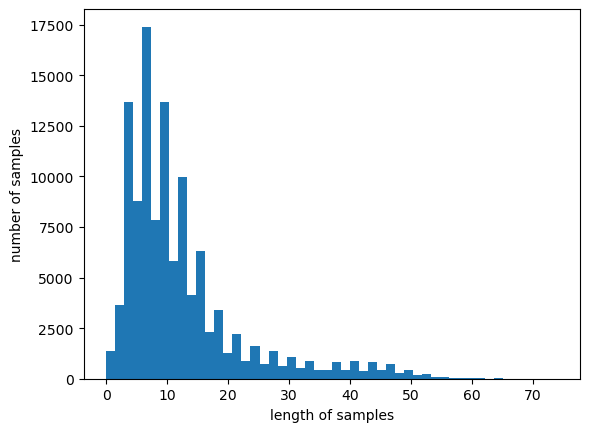

In [46]:
#  전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 확인
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 74이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 12내외의 길이를 가지는 것을 확인.  
모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줘야 한다.  
대부분의 리뷰의 내용이 잘리지 않도록 할 최적의 특정 길이 변수를 max_len 지정한다.

In [47]:
#전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 생성
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [48]:
# 위의 그래프를 봤을 때, max_len = 30이 적당할 것으로 생각됨. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인한다.
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.49703389101914


In [49]:
# 전체 훈련 데이터 중 약 92%의 리뷰가 30이하의 길이를 가지는 것을 확인함. 
# 모든 샘플의 길이를 30으로 맞춘다.

def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [50]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 924 1866  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


훈련 데이터의 첫번째 샘플을 출력하면 길이 30을 맞추기 위해서 뒤에 숫자 0이 붙어있는 것을 확인할 수 있다.

## 8. LSTM을 이용한 네이버 영화 리뷰 분류 모델

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [52]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [53]:
# 레이블 데이터를 파이토치의 텐서 타입으로 변환
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [54]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [55]:
# 훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 파이토치 텐서로 변환하고 배치 단위 연산을 위해 데이터로더로 변환

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [56]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 3635


In [57]:
# 모델 객체를 선언

embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [58]:
# 소프트맥스 회귀를 통해 분류 문제를 진행하므로 손실 함수는 nn.CrossEntropyLoss()를 사용한다
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 9. 평가 코드 작성

In [59]:
# 평가를 진행하기 위해서 모델의 정확도를 측정하는 함수 calculate_accuracy()를 작성
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [60]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

- model.eval(): 모델을 평가 모드로 설정한다. 모델 내부의 모든 레이어에 대해 평가 모드가 활성화된다. 일부 레이어, 예를 들어 드롭아웃이나 배치 정규화는 학습과 평가 시 다르게 동작하기 때문에 이 설정이 중요하다.   

- with torch.no_grad(): 이 문장은 자동 미분 엔진에서 기울기(gradient) 계산을 비활성한다. 평가 중에는 기울기를 계산할 필요가 없으므로, 이렇게 설정하면 메모리를 절약하고 속도를 높일 수 있다. 

## 10. 학습

In [61]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.4942, Train Accuracy: 0.7291
Validation Loss: 0.3661, Validation Accuracy: 0.8357
Validation loss improved from inf to 0.3661. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3223, Train Accuracy: 0.8602
Validation Loss: 0.3460, Validation Accuracy: 0.8507
Validation loss improved from 0.3661 to 0.3460. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2607, Train Accuracy: 0.8910
Validation Loss: 0.3406, Validation Accuracy: 0.8539
Validation loss improved from 0.3460 to 0.3406. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.2042, Train Accuracy: 0.9186
Validation Loss: 0.3661, Validation Accuracy: 0.8537
Epoch 5/5:
Train Loss: 0.1537, Train Accuracy: 0.9414
Validation Loss: 0.4052, Validation Accuracy: 0.8503


## 11. 모델 로드 및 평가

In [62]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올림
model.to(device)

C:\Users\강태희\AppData\Local\Temp\ipykernel_20852\1564938131.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint.pth'))

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [63]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3406
Best model validation accuracy: 0.8539


검증 데이터에 대한 정확도는 85.39%

In [64]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3448
Best model test accuracy: 0.8524


테스트 데이터에 대한 정확도는 85.24%

## 12. 모델 테스트

In [65]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [66]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [67]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [68]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [69]:
test_input = "진짜 왜 이렇게 만들었을까 심란하다"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [70]:
test_input = "감독의 역량이 의심된다"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [71]:
test_input = "오랜만에 괜찮은 영화를 보았다"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'